# Speedtest Results

This notebook organises, compares and visualises the results from different systems.
<br>
Please follow the instructions below to add your system speed test to the mix.

## Initial Setup

1. Create a directory for your personal computer system right next to my "LEGION" and "ROG" folders.
2. Paste your CSV speedtest results into the new directory. Make sure that the file names are a perfect match to:
   - `cpu_results.csv`
   - `gpu_results.csv`
4. In the code cell below, add your system as a new item in `systems`.
   <br>For example:<br>
`systems = ["LEGION", "ROG", "NEW_ITEM"]`
5. Run the notebook!

## Load Result Data from Local Files
First, we will load the information from the root directories specified in `systems`.
<br>
The data is split between different systems and devices.

In [1]:
import pandas as pd

systems = ["LEGION", "ROG"]
devices = ["CPU", "GPU"]

results = {}

for sys in systems:
    device_results = {}
    for dev in devices:
        device_results[dev] = pd.read_csv(sys + "/" + dev.lower() + "_results.csv")
        device_results[dev]["system"] = sys
        device_results[dev]["device"] = dev
        
    results[sys] = device_results

results["LEGION"]["CPU"].head()

,Unnamed: 0,n_estimators,max_features,random_state,n_features,accuracy,time,system,device
0,0,100.0,sqrt,8.0,1540.0,0.956378,69.618245,LEGION,CPU
1,1,100.0,sqrt,8.0,54.0,0.953796,18.689648,LEGION,CPU
2,2,100.0,1.0,8.0,1540.0,0.967006,732.822737,LEGION,CPU
3,3,100.0,1.0,8.0,54.0,0.968219,31.872830,LEGION,CPU
4,4,250.0,sqrt,8.0,1540.0,0.957092,80.407688,LEGION,CPU


## Unify Results Data
Unify the split data into a single DataFrame.

In [2]:
res = {}

count = 0
for sys in systems:    
    for dev in devices:
        res[count] = results[sys][dev]
        count += 1
        
unified_results = pd.concat(
    [res[i] for i in range(count)],
    ignore_index=True,
    axis=0,
)

print("systems:", set(unified_results["system"]))
print("rows:", unified_results.shape[0])
print("cols:", unified_results.shape[1])

systems: {'LEGION', 'ROG'}
rows: 48
cols: 9


## Filter Results

If you'd like to fetch specific information from the unified dataframe, please use the following syntax

In [3]:
unified_results[
(unified_results['n_estimators'] == 500) &
(unified_results['n_features'] == 1540) &
(unified_results['max_features'] == "1.0") &
(unified_results['system'] == "ROG")
]

,Unnamed: 0,n_estimators,max_features,random_state,n_features,accuracy,time,system,device
34,10,500.0,1.0,8.0,1540.0,0.967712,4581.994421,ROG,CPU
46,10,500.0,1.0,8.0,1540.0,0.890304,226.814192,ROG,GPU


## Visualisation Functions
The following cell contains 2 visualization functions that compare between devices and systems.
<br>
Both functions focus on combinations of the variables:
- `['max_features', 'n_estimators']`
- `['max_features', 'n_features']`
- `['n_features', 'n_estimators']`

In [138]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_runtime_by_system(data, combo=['max_features', 'n_estimators']):
    df = pd.DataFrame(data)
    
    # Combine n_features and n_estimators
    df['feature_estimator'] = df[combo[0]].astype(str) + ', ' + df[combo[1]].astype(str)
    
    # create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    
    # choose colours
    colors = ['blue', 'orange', 'teal', 'red', 'pink', 'cyan', 'magenta', 'yellow']
    # fetch devices
    df_gpu = df[df['device'] == 'GPU']
    df_cpu = df[df['device'] == 'CPU']
    
    pivot_gpu = df_gpu.pivot_table(values='time', index='feature_estimator', columns='system', aggfunc='mean')
    pivot_gpu.plot(kind='bar', ax=ax1, width=0.45, color=colors, legend=False)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.set_title('GPU: Runtime by System', fontsize=15, fontweight='bold', pad=20)
    ax1.set_xlabel('('+ combo[0] + ', ' + combo[1] + ')', fontsize=12)
    ax1.set_ylabel('Time (seconds)', fontsize=12)
    ax1.legend(handles, labels, title='System, Avg Time', bbox_to_anchor=(0.7, 0.9), loc='center left')
    ax1.tick_params(axis='x', rotation=45) 
    ax1.autoscale()
    ax1.grid(True, axis='y')
    
    pivot_cpu = df_cpu.pivot_table(values='time', index='feature_estimator', columns='system', aggfunc='mean')
    pivot_cpu.plot(kind='bar', ax=ax2, width=0.45, color=colors, legend=False)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.set_title('CPU: Runtime by System', fontsize=15, fontweight='bold', pad=20)
    ax2.set_xlabel('('+ combo[0] + ', ' + combo[1] + ')', fontsize=12)
    ax2.set_ylabel('Time (seconds)', fontsize=12)
    ax2.legend(handles, labels, title='System, Avg Time', bbox_to_anchor=(0.7, 0.9), loc='center left')
    ax2.tick_params(axis='x', rotation=45)
    ax2.autoscale()
    ax2.grid(True, axis='y')
    
    handles, labels = ax1.get_legend_handles_labels()
    
    # Layout settings
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.subplots_adjust(right=0.85, wspace=0.2)
    
    plt.show()

def plot_runtime_by_device(data, combo=['max_features', 'n_estimators']):
    df = pd.DataFrame(data)

    # Combine n_features and n_estimators
    df['feature_estimator'] = df[combo[0]].astype(str) + ', ' + df[combo[1]].astype(str)
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Choose colours
    colors = ['blue', 'orange', 'pink', 'red', 'teal', 'cyan', 'magenta', 'yellow']
    
    # Fetch systems
    df_legion = df[df['system'] == 'LEGION']
    df_rog = df[df['system'] == 'ROG']
    
    # Subplot 1: LEGION (CPU vs. GPU)
    pivot_legion = df_legion.pivot_table(values='time', index='device', columns='feature_estimator', aggfunc='mean')
    pivot_legion.plot(kind='bar', ax=ax1, width=0.6, color=colors, legend=False)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.set_title('LEGION: Runtime by Device', fontsize=15, fontweight='bold', pad=20)
    ax1.set_xlabel('LEGION Device')
    ax1.set_ylabel('Time (seconds)')
    ax1.legend(handles, labels, title='('+ combo[0] + ', ' + combo[1] + ')', bbox_to_anchor=(0.45, 0.83), loc='center left')
    ax1.tick_params(axis='x', rotation=0)
    ax1.autoscale()
    ax1.grid(True, axis='y')
    
    # Subplot 2: ROG (CPU vs. GPU)
    pivot_rog = df_rog.pivot_table(values='time', index='device', columns='feature_estimator', aggfunc='mean')
    pivot_rog.plot(kind='bar', ax=ax2, width=0.6, color=colors, legend=False)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.set_title('ROG: Runtime by Device', fontsize=15, fontweight='bold', pad=20)
    ax2.set_xlabel('ROG Device', fontsize=12)
    ax2.set_ylabel('Time (seconds)', fontsize=12)
    ax2.legend(handles, labels, title='('+ combo[0] + ', ' + combo[1] + ')', bbox_to_anchor=(0.45, 0.83), loc='center left')
    
    ax2.tick_params(axis='x', rotation=0)
    ax2.autoscale()
    ax2.grid(True, axis='y')
    
    # Add a shared legend for both subplots
    handles, labels = ax1.get_legend_handles_labels()
    
    # Layout settings
    plt.tight_layout()
    plt.subplots_adjust(right=0.85, wspace=0.2)
    
    plt.show()

## Plot Runtime By System
The following plot will compare the same device across different systems based on combinations of n_features and n_estimators.

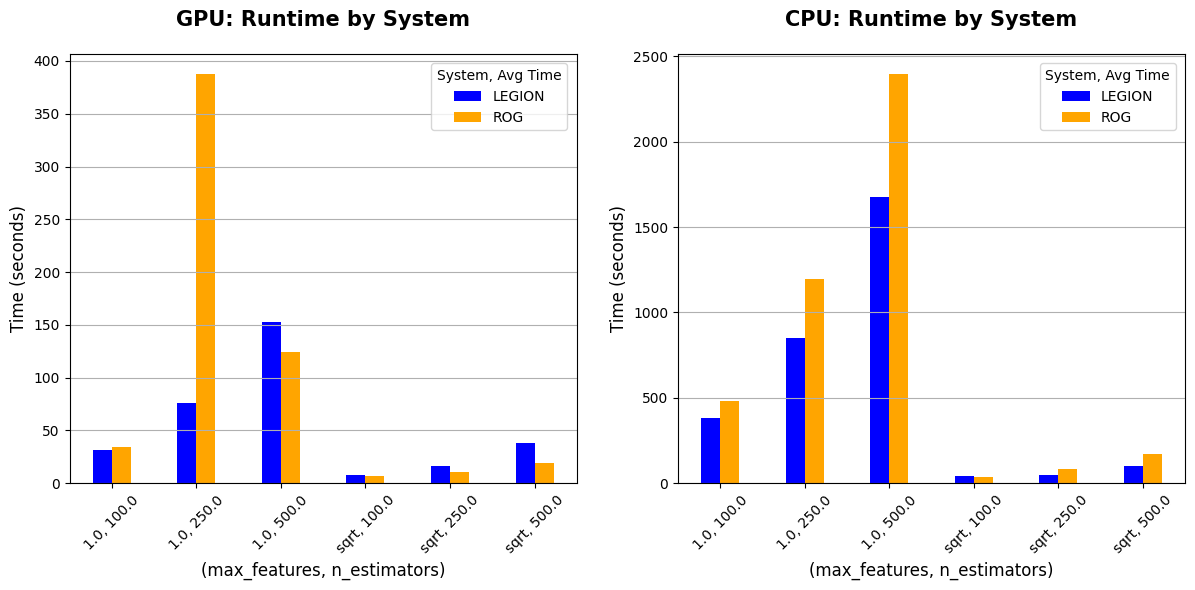

In [139]:
plot_runtime_by_system(unified_results, ['max_features', 'n_estimators'])

## Plot Runtime by Device
The following plot will compare the same system across different devices based on combinations of n_features and n_estimators.

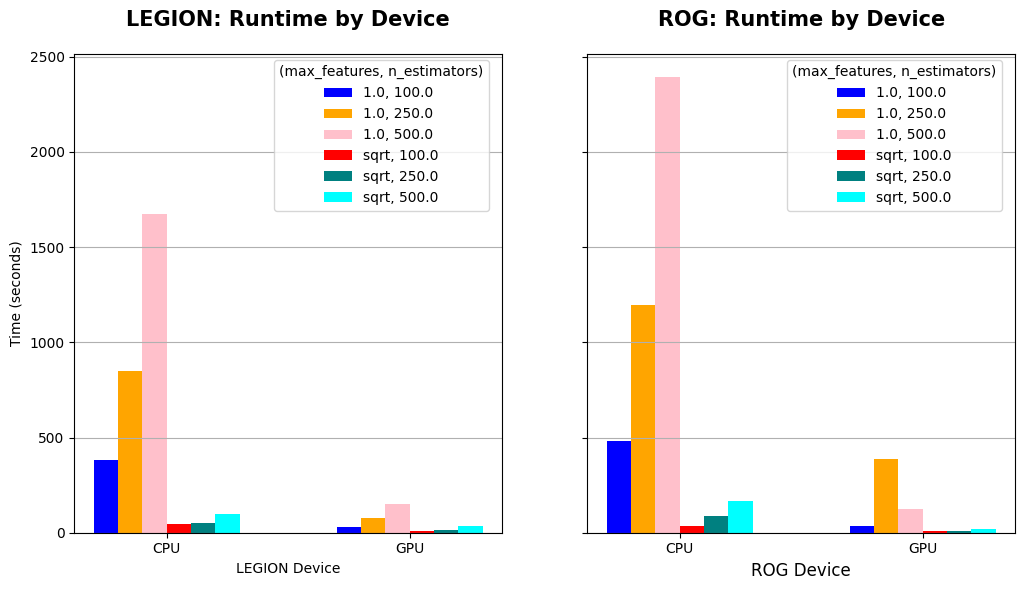

In [134]:
plot_runtime_by_device(unified_results, ['max_features', 'n_estimators'])

## Expanded Device Performance
The following function is an expanded version of the previous functions.
Instead of plotting combinations of two variables, the function below plots combinations of all 3 variables:
<br>
`['max_features', 'n_estimators', 'n_features']`

### Function

In [116]:
def expanded_performance(data, device):
    df = pd.DataFrame(data)
    df_gpu = df[df['device'] == device].copy()
    
    # Create labels for x-axis (combinations)
    df_gpu['combo_label'] = df_gpu.apply(lambda x: f"{int(x['n_features'])} {int(x['n_estimators'])} {x['max_features']}", axis=1)
    combo_labels = df_gpu[df_gpu['system'] == 'LEGION']['combo_label'].unique()
    
    # Prepare data for plotting
    legion_data = df_gpu[df_gpu['system'] == 'LEGION'].sort_values(['n_features', 'n_estimators', 'max_features'])
    rog_data = df_gpu[df_gpu['system'] == 'ROG'].sort_values(['n_features', 'n_estimators', 'max_features'])
    
    # Create the bar chart
    plt.figure(figsize=(14, 6))
    
    x = range(len(combo_labels))
    bar_width = 0.35  # Width of each bar
    
    # Plot bars for LEGION and ROG side by side
    plt.bar(x, legion_data['time'], width=bar_width, label='LEGION', color='blue', align='center')
    plt.bar([i + bar_width for i in x], rog_data['time'], width=bar_width, label='ROG', color='red', align='center')
    
    # Customize the plot
    plt.xlabel('Parameter Combination (n_features n_estimators max_features)', fontsize=12)
    plt.ylabel('Runtime (seconds)', fontsize=12)
    plt.title(device + ' Performance: LEGION vs. ROG', fontsize=20, fontweight='bold', pad=20)
    plt.xticks([i + bar_width / 2 for i in x], combo_labels, rotation=45, ha='right')
    plt.legend(fontsize=15)

    plt.tight_layout()
    plt.show()

### Expanded GPU Runtime
The following chart plots GPU performance across matching parameters on the ROG and LEGION systems.

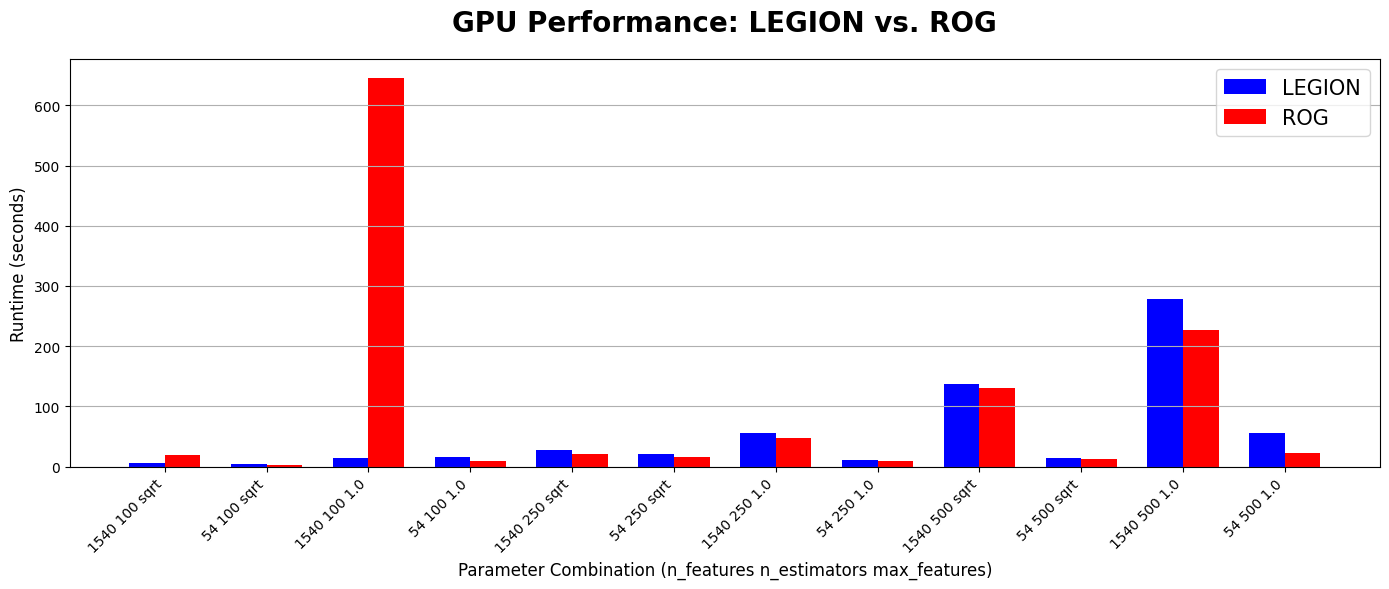

In [117]:
expanded_performance(unified_results, "GPU")

### Expanded CPU Runtime
The following chart plots CPU performance across matching parameters on the ROG and LEGION systems.

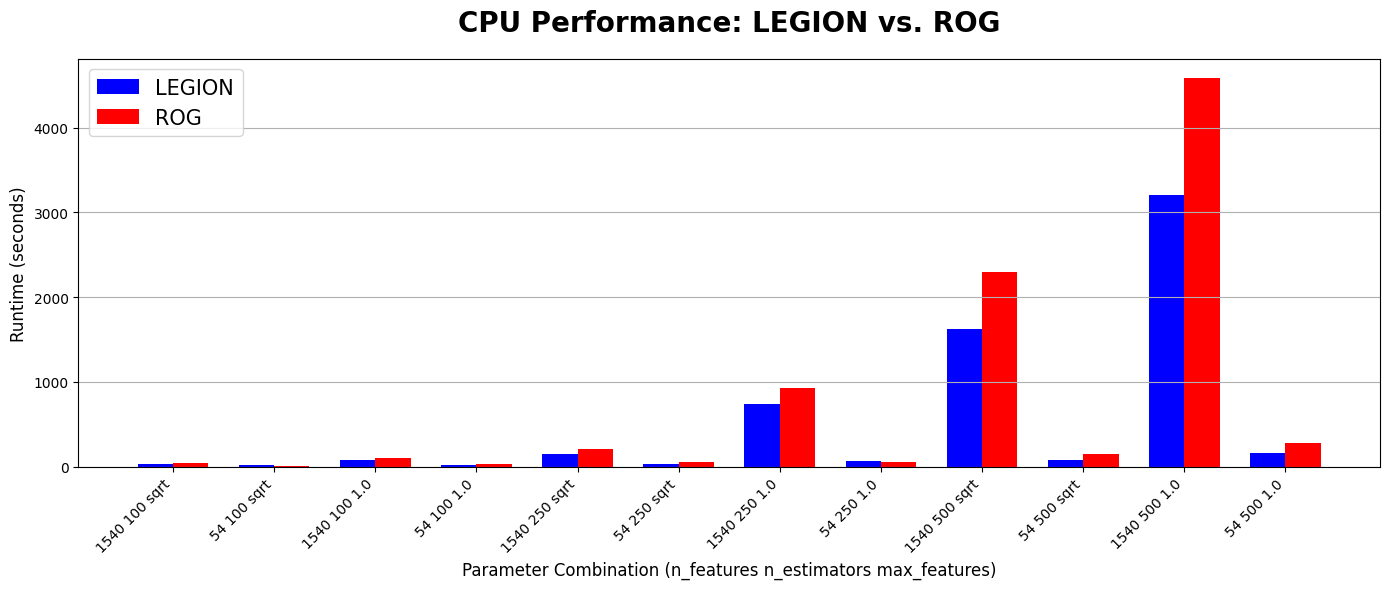

In [118]:
expanded_performance(unified_results, "CPU")

## Expanded Device Runtime Performance Gap

The following function traces the GPU vs CPU performance gap for each triplet of variables on the same system:
<br>
`['max_features', 'n_estimators', 'n_features']`

### Function 

In [95]:
import numpy as np

def device_performance_gap(data, system='LEGION'):
    df_system = data[data['system'] == system].copy()
    devices = data['device'].unique()
    
    # Get unique n_features, n_estimators, max_features combinations for x-axis
    combos = df_system[
        ['n_features', 'n_estimators', 'max_features']
    ].drop_duplicates().sort_values(
        ['n_features', 'n_estimators', 'max_features']
    )
    combo_labels = [f"({int(n_f)}, {int(n_e)}, {m_f})" for n_f, n_e, m_f in combos.values]
    
    # aggregate time (mean) for each device and combination
    df_agg = df_system.groupby(
        ['device', 'n_features', 'n_estimators', 'max_features']
    )['time'].mean().reset_index()
    
    # create bar chart
    plt.figure(figsize=(12, 8)) 
    bar_width = 0.35
    x = np.arange(len(combos)) 
    
    # set colours
    colors = ['orange', 'magenta']
    
    # plot bars for CPU and GPU side by side for each combination
    for idx, dev in enumerate(devices):
        runtimes = []
        for n_f, n_e, m_f in combos.values:
            combo_data = df_agg[(df_agg['device'] == dev) & 
                               (df_agg['n_features'] == n_f) & 
                               (df_agg['n_estimators'] == n_e) & 
                               (df_agg['max_features'] == m_f)]
            runtime = combo_data['time'].values[0] if len(combo_data) > 0 else 0
            runtimes.append(runtime)
        # plot bars, offset by device index (CPU left, GPU right)
        plt.bar(x + idx * bar_width, runtimes, width=bar_width, label=dev, 
                color=colors[idx], align='center', alpha=0.9)
    
    # plot settings
    plt.xlabel('Parameters (n_features, n_estimators, max_features)', fontsize=12)
    plt.ylabel('Runtime (seconds)', fontsize=12)
    plt.title(f'{system} Scikit-Learn Performance: CPU vs. GPU', fontsize=20, fontweight='bold', pad=20)
    plt.xticks(x + bar_width / 2, combo_labels, rotation=45, ha='right')
    plt.grid(True, axis='y', color='grey', linestyle='-', alpha=0.5) 
    plt.legend(title='Device', loc='upper left', bbox_to_anchor=(0.05, 0.9), fontsize=15)
    plt.tight_layout()
    plt.show()

### Legion CPU vs GPU Performance Gap

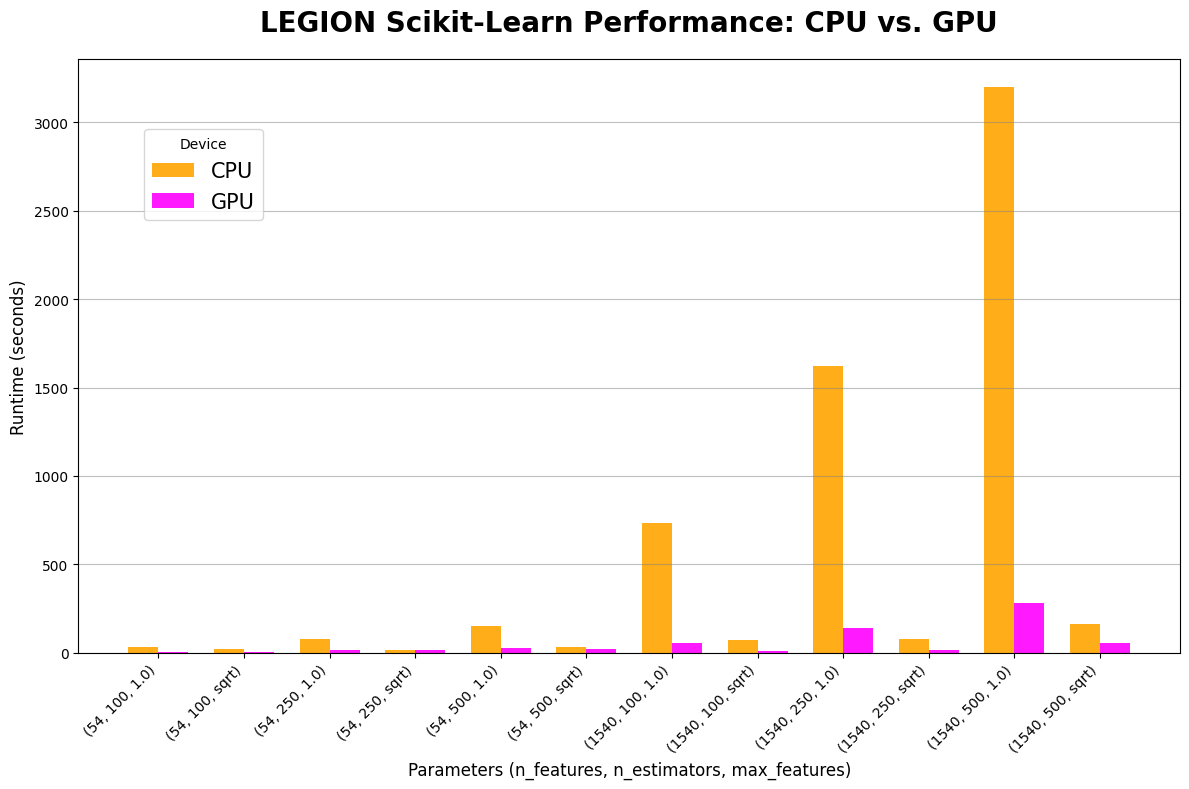

In [97]:
device_performance_gap(unified_results, "LEGION")

### ROG CPU vs GPU Performance Gap

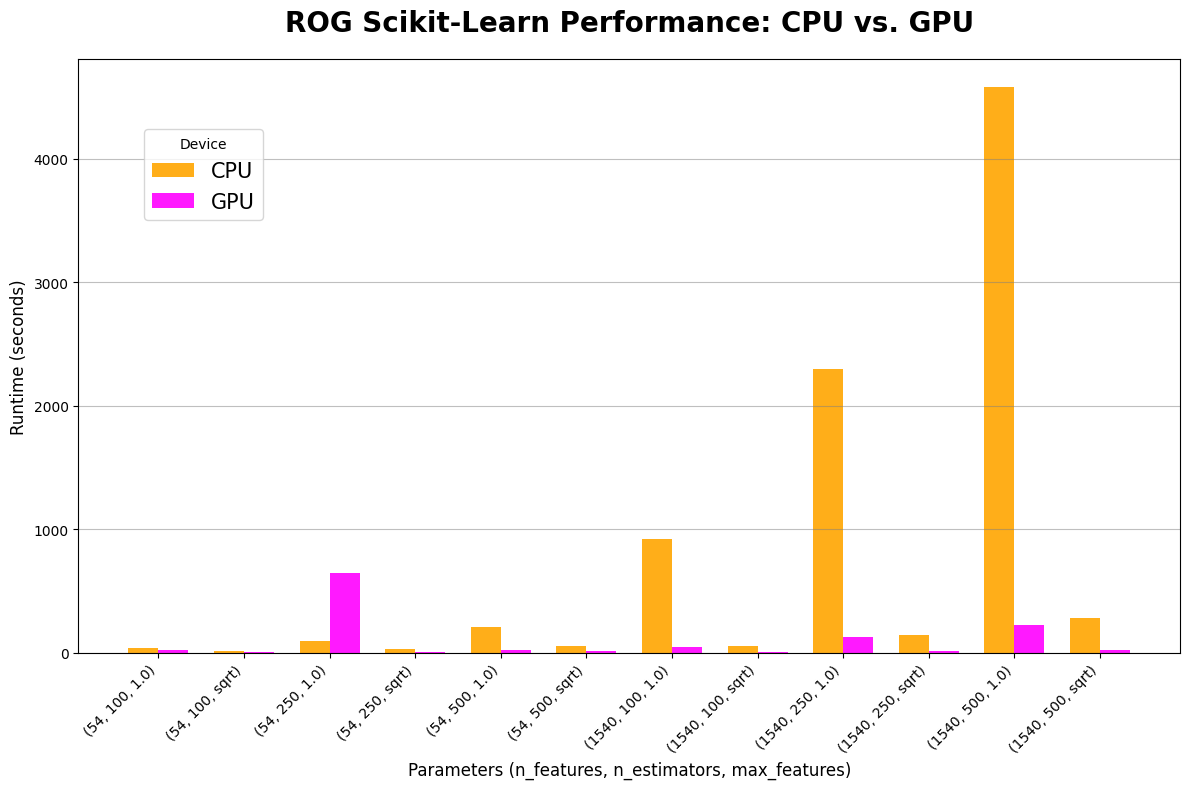

In [99]:
expanded_runtime2(unified_results, "ROG")